In [1]:
from google.colab import files
uploaded = files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c plant-seedlings-classification

Saving kaggle.json to kaggle.json
100% 1.68G/1.69G [00:10<00:00, 190MB/s]
100% 1.69G/1.69G [00:10<00:00, 168MB/s]


In [2]:
!unzip plant-seedlings-classification.zip


Streaming output truncated to the last 5000 lines.
  inflating: test/ad12382d4.png      
  inflating: test/adb7a032c.png      
  inflating: test/ae90f2827.png      
  inflating: test/aecfaed64.png      
  inflating: test/aee6fa3df.png      
  inflating: test/af45e222a.png      
  inflating: test/afa446484.png      
  inflating: test/afcf6abd5.png      
  inflating: test/b026bf8ca.png      
  inflating: test/b03397525.png      
  inflating: test/b0acaff4a.png      
  inflating: test/b130a0632.png      
  inflating: test/b145ba9d4.png      
  inflating: test/b1cd2a91e.png      
  inflating: test/b215531dd.png      
  inflating: test/b2706e2b3.png      
  inflating: test/b29339405.png      
  inflating: test/b30ab4659.png      
  inflating: test/b31292706.png      
  inflating: test/b341d0aab.png      
  inflating: test/b39c71707.png      
  inflating: test/b3d6fdb80.png      
  inflating: test/b3e08b037.png      
  inflating: test/b47691c08.png      
  inflating: test/b4c3df835.png      

In [3]:
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 16
import numpy as np
import os
import pandas as pd
import seaborn as sns
from keras.applications import xception

from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm
import keras.utils as image

In [4]:
!ls ../content/train

 Black-grass	    'Common wheat'	'Scentless Mayweed'
 Charlock	    'Fat Hen'		'Shepherds Purse'
 Cleavers	    'Loose Silky-bent'	'Small-flowered Cranesbill'
'Common Chickweed'   Maize		'Sugar beet'


In [5]:
CATEGORIES = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent',
              'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
NUM_CATEGORIES = len(CATEGORIES)

In [6]:
SAMPLE_PER_CATEGORY = 200
SEED = 1987
data_dir = '../content/'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

In [7]:
for category in CATEGORIES:
    print('{} {} images'.format(category, len(os.listdir(os.path.join(train_dir, category)))))

Black-grass 263 images
Charlock 390 images
Cleavers 287 images
Common Chickweed 611 images
Common wheat 221 images
Fat Hen 475 images
Loose Silky-bent 654 images
Maize 221 images
Scentless Mayweed 516 images
Shepherds Purse 231 images
Small-flowered Cranesbill 496 images
Sugar beet 385 images


In [8]:
train = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(train_dir, category)):
        train.append(['train/{}/{}'.format(category, file), category_id, category])
train = pd.DataFrame(train, columns=['file', 'category_id', 'category'])
train.head(2)
train.shape

(4750, 3)

In [9]:
train.head(5)

,file,category_id,category
0,train/Black-grass/a87fd277c.png,0,Black-grass
1,train/Black-grass/39e9bf4c7.png,0,Black-grass
2,train/Black-grass/5e4d1ee0d.png,0,Black-grass
3,train/Black-grass/b790f7be5.png,0,Black-grass
4,train/Black-grass/75ef53b3b.png,0,Black-grass


In [10]:
train.tail(5)

,file,category_id,category
4745,train/Sugar beet/6bb2545d9.png,11,Sugar beet
4746,train/Sugar beet/8a977c224.png,11,Sugar beet
4747,train/Sugar beet/faaac2544.png,11,Sugar beet
4748,train/Sugar beet/4c9ea912c.png,11,Sugar beet
4749,train/Sugar beet/7ba30d202.png,11,Sugar beet


In [11]:
train = pd.concat([train[train['category'] == c][:SAMPLE_PER_CATEGORY] for c in CATEGORIES])
train = train.sample(frac=1)
train.index = np.arange(len(train))
train.head(2)
train.shape

(2400, 3)

In [12]:
test = []
for file in os.listdir(test_dir):
    test.append(['test/{}'.format(file), file])
test = pd.DataFrame(test, columns=['filepath', 'file'])
test.head(2)
test.shape

(794, 2)

In [13]:
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_dir, filepath), target_size=size)
    img = image.img_to_array(img)
    return img

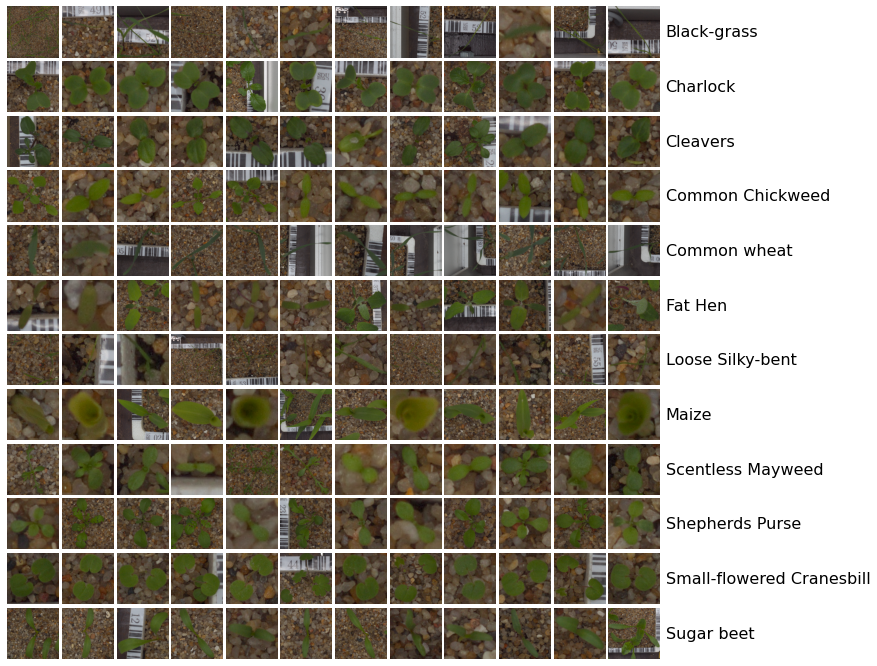

In [14]:
fig = plt.figure(1, figsize=(NUM_CATEGORIES, NUM_CATEGORIES))
grid = ImageGrid(fig, 111, nrows_ncols=(NUM_CATEGORIES, NUM_CATEGORIES), axes_pad=0.05)
i = 0
for category_id, category in enumerate(CATEGORIES):
    for filepath in train[train['category'] == category]['file'].values[:NUM_CATEGORIES]:
        ax = grid[i]
        img = read_img(filepath, (224, 224))
        ax.imshow(img / 255.)
        ax.axis('off')
        if i % NUM_CATEGORIES == NUM_CATEGORIES - 1:
            ax.text(250, 112, filepath.split('/')[1], verticalalignment='center')
        i += 1
plt.show();

In [43]:
np.random.seed(seed=SEED)
rnd = np.random.random(len(train))
train_idx = rnd < 0.8
valid_idx = rnd >= 0.8
ytr = train.loc[train_idx, 'category_id'].values
yv = train.loc[valid_idx, 'category_id'].values
len(ytr), len(yv)

(1899, 501)

In [44]:
INPUT_SIZE=224
POOLING='avg'
x_train=np.zeros((len(train),INPUT_SIZE,INPUT_SIZE,3),dtype=np.float32)
print('Train image shape: {} size: {:,}'.format(x_train.shape,x_train.size))

from keras.applications.vgg16 import VGG16,preprocess_input, decode_predictions
vgg_bottleneck = VGG16(weights='imagenet', include_top=False, pooling=POOLING)


for i,file in tqdm(enumerate(train['file'])):
    img = read_img(os.path.join(data_dir,file),(INPUT_SIZE,INPUT_SIZE))
    x=preprocess_input(np.expand_dims(img.copy(),axis=0)) #need to be changed for every model
    x_train[i]=x

xtrain=x_train[train_idx]
xvalid=x_train[valid_idx]
print((xtrain.shape,xvalid.shape))

Train image shape: (2400, 224, 224, 3) size: 361,267,200


2400it [00:30, 78.12it/s]


((1899, 224, 224, 3), (501, 224, 224, 3))


In [45]:
INPUT_SIZE=224
POOLING='avg'
x_train=np.zeros((len(train),INPUT_SIZE,INPUT_SIZE,3),dtype=np.float32)
print('Train image shape: {} size: {:,}'.format(x_train.shape,x_train.size))

Train image shape: (2400, 224, 224, 3) size: 361,267,200


In [46]:
train_vgg_bf = vgg_bottleneck.predict(xtrain, batch_size=32, verbose=1)
valid_vgg_bf = vgg_bottleneck.predict(xvalid, batch_size=32, verbose=1)
print('VGG train bottleneck features shape: {} size: {:,}'.format(train_vgg_bf.shape, train_vgg_bf.size))
print('VGG valid bottleneck features shape: {} size: {:,}'.format(valid_vgg_bf.shape, valid_vgg_bf.size))

16/16 [==============================] - 15s 952ms/step
VGG train bottleneck features shape: (1899, 512) size: 972,288
VGG valid bottleneck features shape: (501, 512) size: 256,512


In [47]:
import keras
one_hot_labels = keras.utils.to_categorical(ytr, num_classes=12)
valid_labels = keras.utils.to_categorical(yv, num_classes=12)

In [48]:
from keras.models import Sequential
from keras.layers import Dense, Activation
model=Sequential()

model.add(Dense(1000, input_dim=512, activation='relu',kernel_initializer='uniform'))


model.add(Dense(500,input_dim=1000,activation='sigmoid'))


model.add(Dense(150,input_dim=500,activation='sigmoid'))


model.add(Dense(units=12))
model.add(Activation('softmax'))


In [49]:

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1000)              513000    
                                                                 
 dense_13 (Dense)            (None, 500)               500500    
                                                                 
 dense_14 (Dense)            (None, 150)               75150     
                                                                 
 dense_15 (Dense)            (None, 12)                1812      
                                                                 
 activation_3 (Activation)   (None, 12)                0         
                                                                 
Total params: 1,090,462
Trainable params: 1,090,462
Non-trainable params: 0
_________________________________________________________________


In [50]:
%matplotlib inline

In [51]:
history= model.fit(train_vgg_bf,one_hot_labels, epochs=25, batch_size=64,validation_data=(valid_vgg_bf, valid_labels))
print(history.history.keys())


Epoch 1/25
30/30 [==============================] - 1s 14ms/step - loss: 1.9405 - accuracy: 0.3681 - val_loss: 1.3932 - val_accuracy: 0.6148
Epoch 2/25
30/30 [==============================] - 0s 8ms/step - loss: 1.1510 - accuracy: 0.6598 - val_loss: 0.9544 - val_accuracy: 0.7066
Epoch 3/25
30/30 [==============================] - 0s 8ms/step - loss: 0.7728 - accuracy: 0.7704 - val_loss: 0.7566 - val_accuracy: 0.7585
Epoch 4/25
30/30 [==============================] - 0s 8ms/step - loss: 0.5627 - accuracy: 0.8331 - val_loss: 0.6552 - val_accuracy: 0.7804
Epoch 5/25
30/30 [==============================] - 0s 8ms/step - loss: 0.4017 - accuracy: 0.8926 - val_loss: 0.5323 - val_accuracy: 0.8164
Epoch 6/25
30/30 [==============================] - 0s 8ms/step - loss: 0.2900 - accuracy: 0.9289 - val_loss: 0.5146 - val_accuracy: 0.8224
Epoch 7/25
30/30 [==============================] - 0s 8ms/step - loss: 0.2075 - accuracy: 0.9489 - val_loss: 0.4900 - val_accuracy: 0.8423
Epoch 8/25
30/30 [=

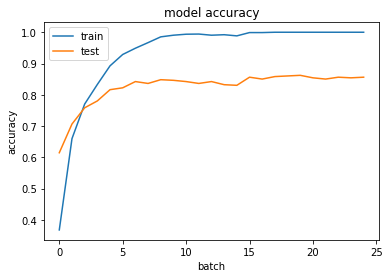

In [52]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('batch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
model.save_weights('VGG16 val 25 epocs.h5')

In [53]:
import os
print(os.path.getsize("VGG16 val 25 epocs.h5")/1048576, "MB")

4.1789093017578125 MB
